<a href="https://colab.research.google.com/github/tedyadika/Machine-learning-from-scratch-main/blob/main/cnn_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
from keras.applications import VGG16
from keras import models
from keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization
from tensorflow.keras.activations import relu
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import zipfile
from google.colab import drive
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


if working with zipfile  you will need to run this to extract images in this case the zipfile is in google drive and i am using colab

In [5]:
drive.mount('/content/drive')
zip_file_path = '/content/drive/MyDrive/images.zip' # path to zipped images
image_folder = '/content/drive/MyDrive/images2'## path to save all the unzipped images

Mounted at /content/drive


In [ ]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(image_folder)


## Parameters

In [3]:
"""
assuming images are not yet sorted into folders based on label
#(if you have images and csv with images and its label here we are reading csv file that contains the image name and the label
ie just 2 columns in the csv)
"""
test_labels = '/content/drive/MyDrive/image_label/galaxy_morphology_test.csv'  # test label
train_labels = '/content/drive/MyDrive/image_label/galaxy_morphology_train.csv'# train label
## path where we will have folders containing labeled images ie images of same label will go to one folder
output_labeled_images = '/content/drive/MyDrive/galaxy_morphology'

## Read csv data

In [4]:
# Read and  CSV files
train_label_csv = pd.read_csv(train_labels)
test_label_csv = pd.read_csv(test_labels)

## Merge csv

In [5]:
# Merge or append the two dataframes
all_data_merged_df = pd.concat([test_label_csv, train_label_csv], ignore_index=True)

In [6]:
## this class is responsible for reading the csv with labels and sorting our images into folders based on the label
class ImageProcessor:
    def __init__(self, merged_df, image_folder, output_folder, label_column='galaxy_morphology', image_name_column='GalaxyID'):
        self.merged_df = merged_df
        self.image_folder = image_folder
        self.output_folder = output_folder
        self.label_column = label_column
        self.image_name_column = image_name_column

    def create_folders(self, labels):
        for label in labels:
            folder_path = os.path.join(self.output_folder, str(label))
            os.makedirs(folder_path, exist_ok=True)

    def process_images(self):
        # Create folders for each label
        labels = self.merged_df[self.label_column].unique()
        print(labels)
        self.create_folders(labels)

        # Process each row in the merged CSV
        for index, row in self.merged_df.iterrows():
            image_name = str(row[self.image_name_column]) + '.jpg'
            label = row[self.label_column]
            #print(image_name)
            image_path = os.path.join(self.image_folder, image_name)
            output_path = os.path.join(self.output_folder, str(label), image_name)

            # Check if the image file exists
            if os.path.exists(image_path):
                # Open and save the image to the corresponding folder
                img = Image.open(image_path)
                img.save(output_path)
                print(f"Image '{image_name}' saved to folder '{label}'")
            else:
                print(f"Image '{image_name}' not found!")



In [7]:
"""

this will be our CNN class that can perform several actions based on the functions we have but idealy it reads our imaged
reshapes and train a CNN the method of training assumes 3 classes of images being classified so you might have to change that depending on your
usecase the class will also visualize the images before and after scaling to make sure we have the right images
"""
class ImageProcessingModel:

    def __init__(self, output_folder):
        self.output_folder = output_folder
        self.data = None
        self.scaled_data = None
        self.train = None
        self.val = None
        self.test = None
        self.model = None
        self.history = None

    def load_data(self):
        self.data = tf.keras.utils.image_dataset_from_directory(self.output_folder)

    def print_data_summary(self):
        for images, labels in self.data.take(1):
            print(labels)
            print(images.shape)

    def preprocess_data(self):
        data_iterator = self.data.as_numpy_iterator()
        batch = data_iterator.next()
        print(batch[1])
        fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
        for idx, img in enumerate(batch[0][:4]):
            ax[idx].imshow(img.astype(int))
            ax[idx].set_title(batch[1][idx])

        self.scaled_data = self.data.map(lambda x, y: (x / 255, y))

    def print_scaled_data_summary(self):
        scaled_data_iterator = self.scaled_data.as_numpy_iterator()
        scaled_batch = scaled_data_iterator.next()
        print(scaled_batch[1])
        fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
        for idx, img in enumerate(scaled_batch[0][:4]):
            ax[idx].imshow(img)
            ax[idx].set_title(scaled_batch[1][idx])

    def split_data(self):
        train_size = int(len(self.scaled_data) * 0.7)
        test_size = int(len(self.scaled_data) * 0.2)
        val_size = int(len(self.scaled_data) * 0.1)

        self.train = self.scaled_data.take(train_size)
        self.val = self.scaled_data.skip(train_size).take(val_size)
        self.test = self.scaled_data.skip(train_size + val_size).take(test_size)

    def build_model(self):
        model = Sequential()
        model.add(Conv2D(3, (3, 3), strides=1, activation=relu, input_shape=(256, 256, 3)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(2, (3, 3), strides=1, activation=relu))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(3, (3, 3), strides=1, activation=relu))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(256, activation=relu))
        model.add(Dropout(0.5))
        model.add(Dense(3, activation='softmax'))
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    def build_model_with_base(self, base_model=VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))):
        for layer in base_model.layers:
            layer.trainable = False
        model = Sequential()
        model.add(base_model)
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        #model.add(Dropout(0.5))
        model.add(Dense(3, activation='softmax'))
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model


    def train_model(self, epochs=3):
        self.model = self.build_model_with_base()
        self.model.summary()
        self.history = self.model.fit(self.train, epochs=epochs, validation_data=self.val)

    def plot_loss_history(self):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def evaluate_test_set(self):
        if self.test is None or self.model is None:
            print("Test set or model not available. Please load data and train the model.")
            return

        test_results = self.model.evaluate(self.test)
        print(f"\nTest Set - Loss: {test_results[0]}, Accuracy: {test_results[1]}")

        # Predictions on the test set
        test_pred = np.argmax(self.model.predict(self.test), axis=1)
        true_labels = np.concatenate([y for x, y in self.test], axis=0)

        # Confusion Matrix
        cm = confusion_matrix(true_labels, test_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"],
                    yticklabels=["Class 0", "Class 1", "Class 2"])
        plt.title("Confusion Matrix - Test Set")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

        # Classification Report
        class_report = classification_report(true_labels, test_pred, target_names=["Class 0", "Class 1", "Class 2"])
        print("Classification Report - Test Set:")
        print(class_report)


    def intentionally_overfit_model(self, epochs=20):
        # Intentionally choose hyperparameters to overfit the model
        self.model = Sequential()
        self.model.add(Conv2D(32, (3, 3), strides=1, activation='relu', input_shape=(256, 256, 3)))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Flatten())
        self.model.add(Dense(256, activation='relu'))
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(3, activation='softmax'))
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        self.history = self.model.fit(self.train, epochs=epochs, validation_data=self.val)

        # Plot loss history
        self.plot_loss_history()

    def apply_regularization(self, regularization_type='dropout', regularization_param=0.5):
        # Choose regularization technique
        if regularization_type == 'dropout':
            self.model = self.build_model_with_dropout(dropout_rate=regularization_param)
        elif regularization_type == 'batch_norm':
            self.model = self.build_model_with_batch_norm(optimizer='adam', batch_norm_momentum=regularization_param)
        elif regularization_type == 'l1':
            self.model = self.build_model_with_l1_regularizer(regularization_param)
        elif regularization_type == 'l2':
            self.model = self.build_model_with_l2_regularizer(regularization_param)
        else:
            print("Invalid regularization type. Choose 'dropout', 'batch_norm', 'l1', or 'l2'.")
            return

        # Train the model
        self.history = self.model.fit(self.train, epochs=3, validation_data=self.val)

        # Plot loss history
        self.plot_loss_history()

    def build_model_with_dropout(self, dropout_rate):
        model = Sequential()
        model.add(Conv2D(3, (3, 3), strides=1, activation=relu, input_shape=(256, 256, 3)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(2, (3, 3), strides=1, activation=relu))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(3, (3, 3), strides=1, activation=relu))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(256, activation=relu))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(3, activation='softmax'))
        model.add(Dropout(dropout_rate))
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    def build_model_with_batch_norm(self, optimizer='adam', batch_norm_momentum=0.99):
        model = Sequential()
        model.add(Conv2D(3, (3, 3), strides=1, activation=relu, input_shape=(256, 256, 3)))
        model.add(BatchNormalization(momentum=batch_norm_momentum))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(2, (3, 3), strides=1, activation=relu))
        model.add(BatchNormalization(momentum=batch_norm_momentum))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(3, (3, 3), strides=1, activation=relu))
        model.add(BatchNormalization(momentum=batch_norm_momentum))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(5, activation=relu))
        model.add(Dense(3, activation='softmax'))
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    def build_model_with_l1_regularizer(self, l1_param):
        model = Sequential()
        model.add(Conv2D(3, (3, 3), strides=1, activation=relu, input_shape=(256, 256, 3), kernel_regularizer=tf.keras.regularizers.l1(l1_param)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(2, (3, 3), strides=1, activation=relu, kernel_regularizer=tf.keras.regularizers.l1(l1_param)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(3, (3, 3), strides=1, activation=relu, kernel_regularizer=tf.keras.regularizers.l1(l1_param)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(5, activation=relu))
        model.add(Dense(3, activation='softmax'))
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    def build_model_with_l2_regularizer(self, l2_param):
        model = Sequential()
        model.add(Conv2D(3, (3, 3), strides=1, activation=relu, input_shape=(256, 256, 3), kernel_regularizer=tf.keras.regularizers.l2(l2_param)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(2, (3, 3), strides=1, activation=relu, kernel_regularizer=tf.keras.regularizers.l2(l2_param)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(3, (3, 3), strides=1, activation=relu, kernel_regularizer=tf.keras.regularizers.l2(l2_param)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(5, activation=relu))
        model.add(Dense(3, activation='softmax'))
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model


    def process_images(self):
        self.load_data()
        self.print_data_summary()
        self.preprocess_data()
        self.print_scaled_data_summary()
        self.split_data()
        self.train_model()
        self.plot_loss_history()



58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
##tf.keras.utils.image_dataset_from_directory??

In [ ]:
#since keras has the data pipeline we want to have our data processed as it is being loaded
#we want to scale our data between 0 and 1 and for images we can devide by 255

In [ ]:
"""
runing this will call our ImageProcessor that will sort our images
"""
image_processor = ImageProcessor(all_data_merged_df, image_folder, output_labeled_images, label_column='galaxy_morphology', image_name_column='GalaxyID')
image_processor.process_images()

Found 25724 files belonging to 3 classes.
tf.Tensor([0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 1], shape=(32,), dtype=int32)
(32, 256, 256, 3)
[0 0 1 0 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 0 1 0]
[1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 1]
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 32768)             0         
                                                                 
 dense_20 (Dense)            (None, 256)               8388864   
                                                                 
 dense_21 (Dense)            (None, 3)                 771       
                                                                 
Total params: 23104323 

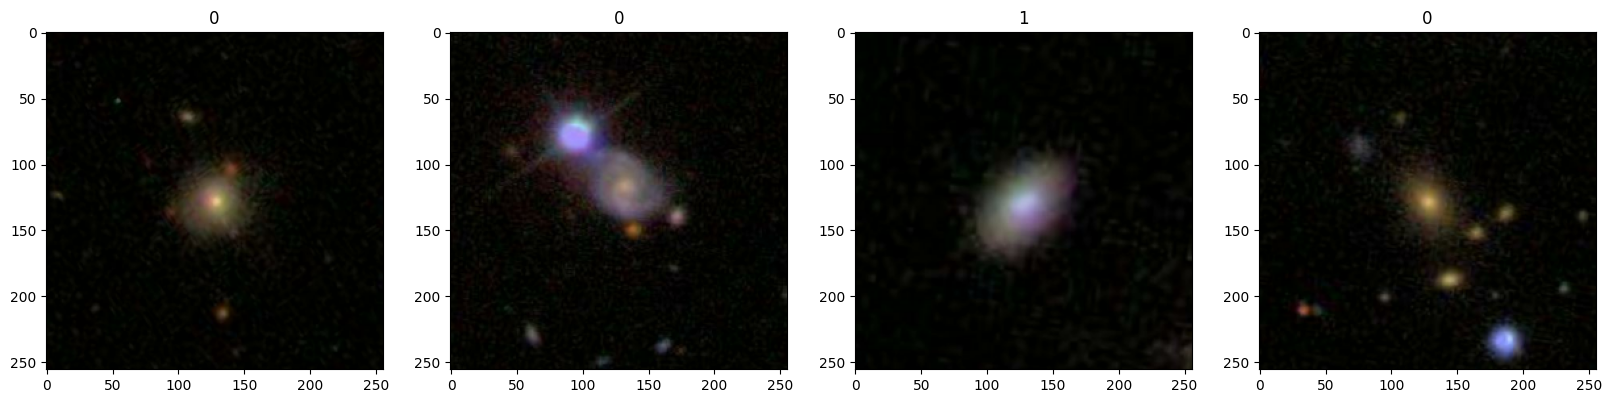

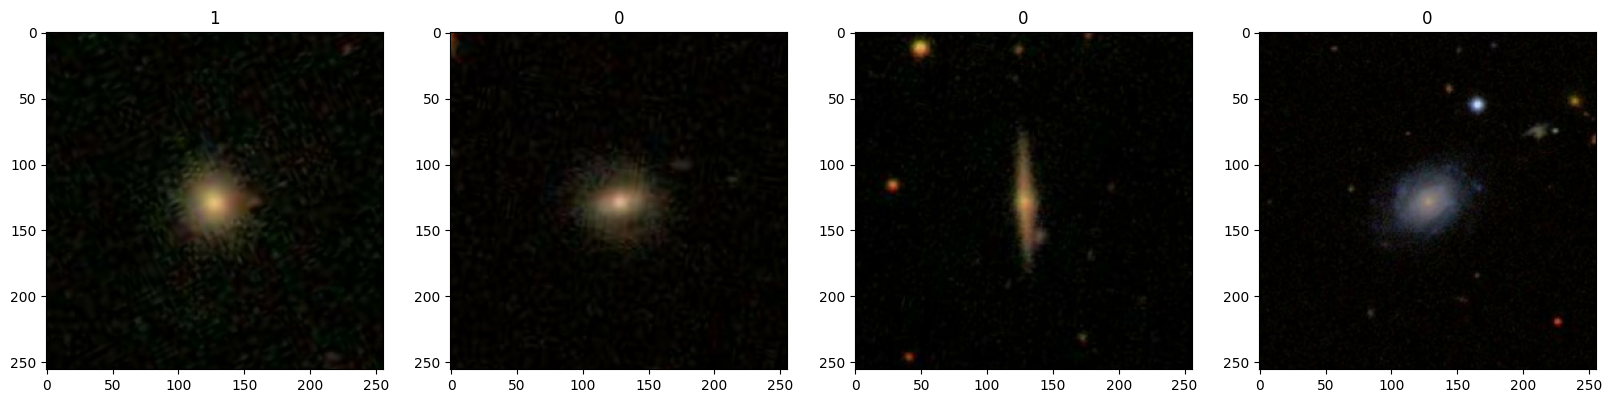

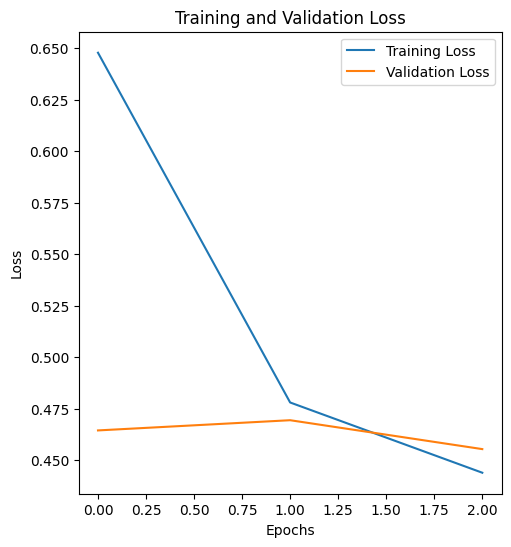

160/160 [==============================] - 185s 925ms/step - loss: 0.4724 - accuracy: 0.7828

Test Set - Loss: 0.472377210855484, Accuracy: 0.7828124761581421
160/160 [==============================] - 66s 172ms/step


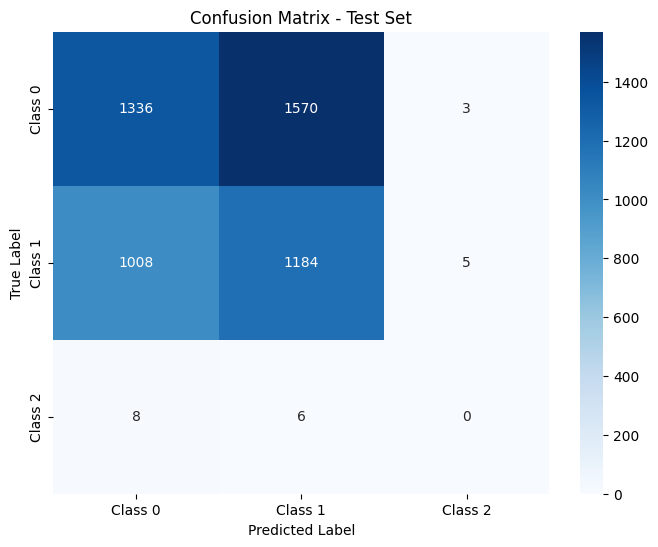

Classification Report - Test Set:
              precision    recall  f1-score   support

     Class 0       0.57      0.46      0.51      2909
     Class 1       0.43      0.54      0.48      2197
     Class 2       0.00      0.00      0.00        14

    accuracy                           0.49      5120
   macro avg       0.33      0.33      0.33      5120
weighted avg       0.51      0.49      0.49      5120



In [ ]:
CNN_image_model = ImageProcessingModel(output_labeled_images)
CNN_image_model.process_images()
CNN_image_model.evaluate_test_set()

Epoch 1/20
322/322 [==============================] - 60s 175ms/step - loss: 0.9547 - accuracy: 0.4963 - val_loss: 0.8441 - val_accuracy: 0.5217
Epoch 2/20
322/322 [==============================] - 72s 221ms/step - loss: 0.6811 - accuracy: 0.6656 - val_loss: 0.5077 - val_accuracy: 0.7711
Epoch 3/20
322/322 [==============================] - 74s 229ms/step - loss: 0.4022 - accuracy: 0.8366 - val_loss: 0.5634 - val_accuracy: 0.7677
Epoch 4/20
322/322 [==============================] - 72s 223ms/step - loss: 0.2226 - accuracy: 0.9148 - val_loss: 0.5274 - val_accuracy: 0.8057
Epoch 5/20
322/322 [==============================] - 72s 222ms/step - loss: 0.1046 - accuracy: 0.9655 - val_loss: 0.5656 - val_accuracy: 0.7942
Epoch 6/20
322/322 [==============================] - 72s 221ms/step - loss: 0.0642 - accuracy: 0.9786 - val_loss: 0.7870 - val_accuracy: 0.7840
Epoch 7/20
322/322 [==============================] - 72s 222ms/step - loss: 0.0598 - accuracy: 0.9793 - val_loss: 0.7868 - val_ac

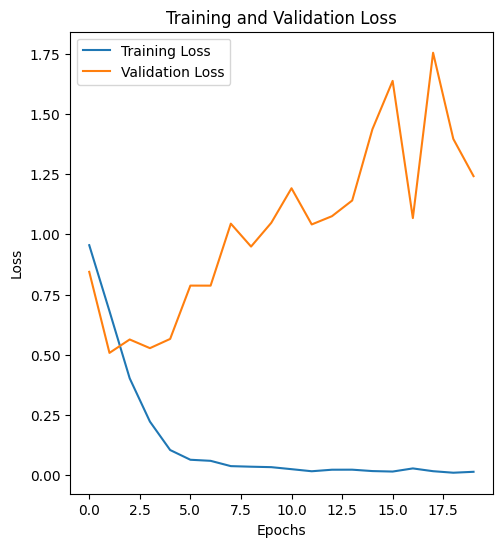

In [ ]:
# Intentionally overfit the model
CNN_image_model.intentionally_overfit_model()

Epoch 1/3
322/322 [==============================] - 56s 158ms/step - loss: 0.9464 - accuracy: 0.4699 - val_loss: 0.8890 - val_accuracy: 0.4735
Epoch 2/3
322/322 [==============================] - 51s 158ms/step - loss: 0.9154 - accuracy: 0.4871 - val_loss: 0.8917 - val_accuracy: 0.4796
Epoch 3/3
322/322 [==============================] - 69s 213ms/step - loss: 0.9034 - accuracy: 0.4945 - val_loss: 0.8943 - val_accuracy: 0.4823


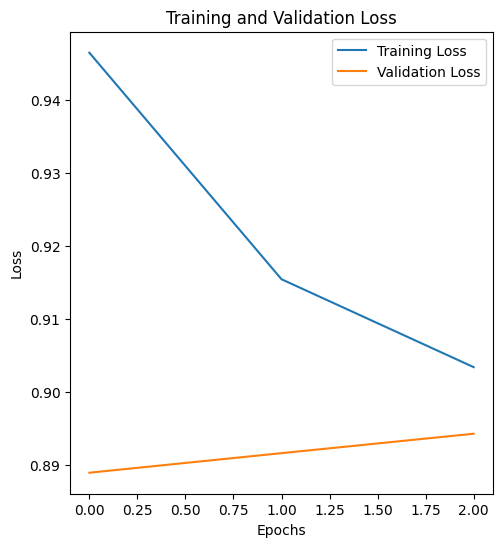

In [ ]:
# Apply dropout regularization
CNN_image_model.apply_regularization(regularization_type='dropout', regularization_param=0.5)

Epoch 1/3
322/322 [==============================] - 71s 214ms/step - loss: 0.8731 - accuracy: 0.4943 - val_loss: 0.9240 - val_accuracy: 0.4742
Epoch 2/3
322/322 [==============================] - 69s 213ms/step - loss: 0.8001 - accuracy: 0.5330 - val_loss: 0.8060 - val_accuracy: 0.5516
Epoch 3/3
322/322 [==============================] - 69s 213ms/step - loss: 0.7561 - accuracy: 0.5726 - val_loss: 0.8269 - val_accuracy: 0.5693


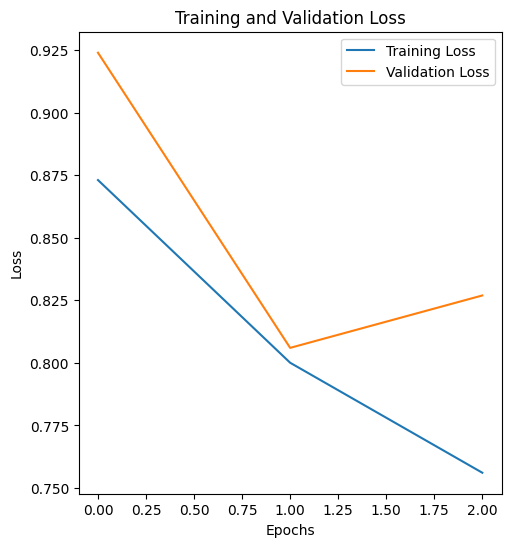

In [ ]:
# Apply batch normalization
CNN_image_model.apply_regularization(regularization_type='batch_norm', regularization_param=0.99)

Epoch 1/3
322/322 [==============================] - 68s 201ms/step - loss: 1.1025 - accuracy: 0.4926 - val_loss: 0.8983 - val_accuracy: 0.4810
Epoch 2/3
322/322 [==============================] - 66s 204ms/step - loss: 0.8855 - accuracy: 0.4942 - val_loss: 0.8750 - val_accuracy: 0.4912
Epoch 3/3
322/322 [==============================] - 69s 213ms/step - loss: 0.8834 - accuracy: 0.4950 - val_loss: 0.8813 - val_accuracy: 0.4878


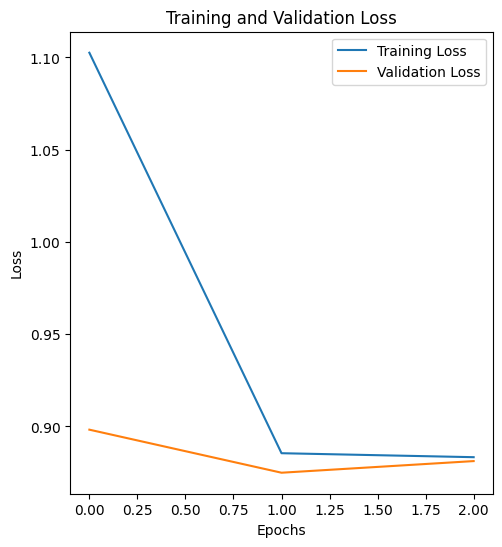

In [ ]:
# Apply L1 regularization
CNN_image_model.apply_regularization(regularization_type='l1', regularization_param=0.01)

Epoch 1/3
322/322 [==============================] - 50s 150ms/step - loss: 0.9298 - accuracy: 0.4883 - val_loss: 0.8907 - val_accuracy: 0.4823
Epoch 2/3
322/322 [==============================] - 69s 212ms/step - loss: 0.8922 - accuracy: 0.4835 - val_loss: 0.8837 - val_accuracy: 0.4851
Epoch 3/3
322/322 [==============================] - 67s 205ms/step - loss: 0.8841 - accuracy: 0.4859 - val_loss: 0.8740 - val_accuracy: 0.4898


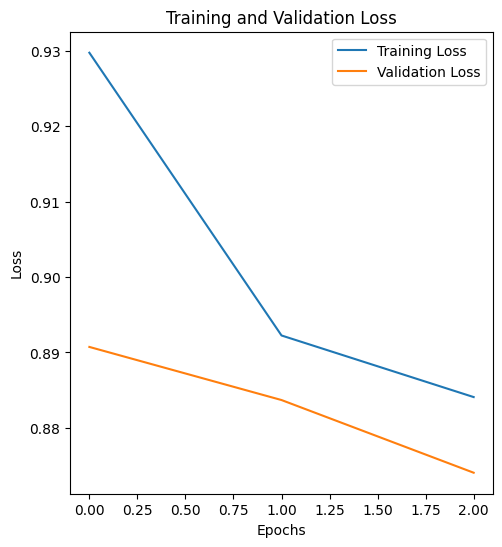

In [ ]:
# Apply L2 regularization
CNN_image_model.apply_regularization(regularization_type='l2', regularization_param=0.01)